In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Dataviz classification")

In [3]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math  
import datetime
import time

Using TensorFlow backend.


In [0]:
#Default dimensions we found online
img_width, img_height = 224, 224  
   
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5' 

# loading up our datasets
train_data_dir = 'training/'  
validation_data_dir = "validation/"
   
# number of epochs to train top model  
epochs = 100 #this has been changed after multiple model run  
# batch size used by flow_from_directory and predict_generator  
batch_size = 20

In [5]:
vgg16 = applications.VGG16(include_top=False, weights='imagenet')

In [0]:
datagen = ImageDataGenerator(rescale=1. / 255)  #needed to create the bottleneck .npy files

In [7]:
'''#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
   
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)  
   
np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)'''

"#__this can take an hour and half to run so only run it once. \n#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__\n\nstart = datetime.datetime.now()\n   \ngenerator = datagen.flow_from_directory(  \n     train_data_dir,  \n     target_size=(img_width, img_height),  \n     batch_size=batch_size,  \n     class_mode=None,  \n     shuffle=False)  \n   \nnb_train_samples = len(generator.filenames)  \nnum_classes = len(generator.class_indices)  \n   \npredict_size_train = int(math.ceil(nb_train_samples / batch_size))  \n   \nbottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)  \n   \nnp.save('bottleneck_features_train.npy', bottleneck_features_train)\nend= datetime.datetime.now()\nelapsed= end-start\nprint ('Time: ', elapsed)"

In [8]:
"""
#__this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)"""

"\n#__this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__\n\nstart = datetime.datetime.now()\ngenerator = datagen.flow_from_directory(  \n     validation_data_dir,  \n     target_size=(img_width, img_height),  \n     batch_size=batch_size,  \n     class_mode=None,  \n     shuffle=False)  \n   \nnb_validation_samples = len(generator.filenames)  \n   \npredict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  \n   \nbottleneck_features_validation = vgg16.predict_generator(  \n     generator, predict_size_validation)  \n   \nnp.save('bottleneck_features_validation.npy', bottleneck_features_validation) \nend= datetime.datetime.now()\nelapsed= end-start\nprint ('Time: ', elapsed)"

In [9]:
print('-'*117)

---------------------------------------------------------------------------------------------------------------------


In [10]:
#training data
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 1055 images belonging to 6 classes.


In [11]:
#validation data
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

Found 355 images belonging to 6 classes.


In [12]:
len(validation_data)

355

In [13]:
len(validation_labels)

355

In [14]:
#This is the best model we found. For additional models, check out I_notebook.ipynb
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(100))
model.add(keras.layers.LeakyReLU(alpha=0.3))  
model.add(Dropout(0.5))  
model.add(Dense(50))  
model.add(keras.layers.LeakyReLU(alpha=0.3))
model.add(Dropout(0.5)) 
model.add(Dense(num_classes, activation='softmax'))  

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc'])  

history = model.fit(train_data, train_labels,  
      epochs=epochs,
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1055 samples, validate on 355 samples
Epoch 1/100
1055/1055 [==============================] - 1s 992us/step - loss: 1.3803 - acc: 0.5052 - val_loss: 1.4794 - val_acc: 0.3465
Epoch 2/100
1055/1055 [==============================] - 0s 381us/step - loss: 0.8202 - acc: 0.7308 - val_loss: 1.1058 - val_acc: 0.5746
Epoch 3/100
1055/1055 [==============================] - 0s 341us/step - loss: 0.6644 - acc: 0.7507 - val_loss: 1.3799 - val_acc: 0.4394
Epoch 4/100
1055/1055 [==============================] - 0s 359us/step - loss: 0.6032 - acc: 0.8085 - val_loss: 1.0391 - val_acc: 0.6141
Epoch 5/100
1055/1055 [==============================] - 0s 340us/step - loss: 0.5181 - acc: 0.8246 - val_loss: 1.1019 - val_acc: 0.5859
Epoch 6/100
1055/1055 [==============================]

In [15]:
#Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               2508900   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)               

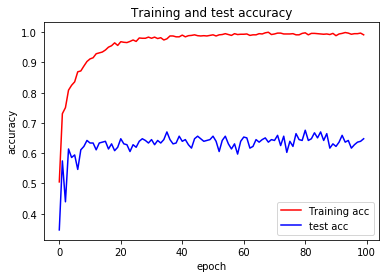

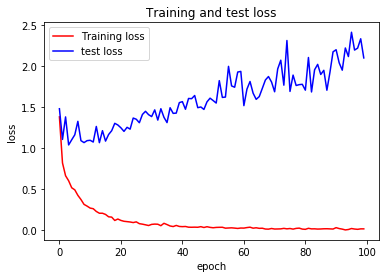

In [16]:
#Graphing our training and test
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='test acc')
plt.title('Training and test accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='test loss')
plt.title('Training and test loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [18]:
tags = ['bar', 'info', 'line', 'map', 'other', 'scatter']
classification_metrics = metrics.classification_report(validation_labels, preds, target_names=tags )
print(classification_metrics)

              precision    recall  f1-score   support

         bar       0.52      0.89      0.66        73
        info       0.55      0.59      0.57        73
        line       0.91      0.62      0.74       131
         map       0.77      0.74      0.76        50
       other       0.29      0.08      0.13        24
     scatter       0.00      0.00      0.00         4

   micro avg       0.66      0.64      0.65       355
   macro avg       0.51      0.49      0.47       355
weighted avg       0.68      0.64      0.64       355
 samples avg       0.64      0.64      0.64       355



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
